In [6]:
# Process Description Column

In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from transformers import BertTokenizer, BertModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

import pickle

In [8]:
# import os
# show current dir
os.getcwd()

'c:\\Users\\frlan\\Documents\\NLP\\experiments'

In [11]:
# read data 

listings = pd.read_csv("dataset\listings\listings.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'dataset\\listings\\listings.csv'

In [ ]:
listings.description.head()

0    Highlights<br />*Located only 5 minutes from C...
1    Quiet Garden View Room & Super Fast Wi-Fi<br /...
2    17th century Dutch townhouse in the heart of t...
3    Stylish and romantic houseboat on fantastic hi...
4    <b>The space</b><br />In a monumental house ri...
Name: description, dtype: object

In [ ]:
listings.review_scores_rating.head()

0    4.85
1    4.89
2    4.44
3    4.94
4    4.88
Name: review_scores_rating, dtype: float64

## Visualization of target variables


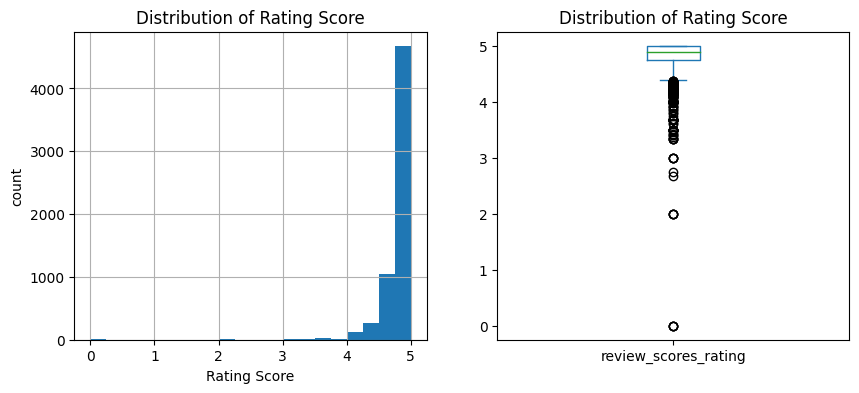

In [ ]:
# The Rating score column
fig = plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

listings.review_scores_rating.hist(ax = ax1, bins = 20)
ax1.set_title('Distribution of Rating Score')
ax1.set_xlabel('Rating Score')
ax1.set_ylabel('count')

# The Log Price column
plot = listings.review_scores_rating.plot(kind = 'box', ax = ax2)
ax2.set_title('Distribution of Rating Score')

plt.show()

In [ ]:
# check na in rating score
listings.review_scores_rating.isna().sum()

648

In [ ]:
# fill na with mean
listings.review_scores_rating.fillna(listings.review_scores_rating.mean(), inplace = True)

We can bin the Review ratings based on 3 approaches

* Based on values
* Based on number of data points in the bins
* Based on Clustering

In [ ]:
listings.review_scores_rating.values

array([4.85, 4.89, 4.44, ..., 4.57, 4.93, 4.94])

Text(0, 0.5, 'count')

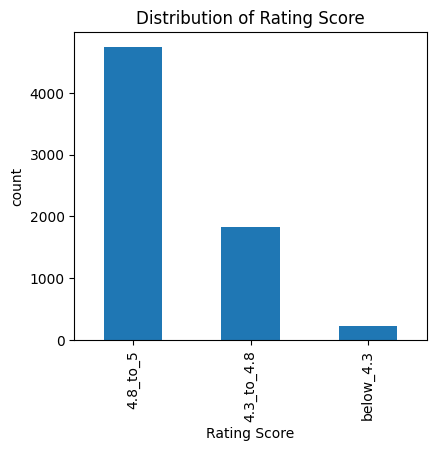

In [ ]:
# Create bins based on review_scores_rating
bins = [0, 4.3, 4.8, 5]

listings_classification = listings.assign(
    rating_bin_ep = pd.cut(
        listings['review_scores_rating'],
        bins=bins,
        labels=['below_4.3', '4.3_to_4.8', '4.8_to_5']
    )
)

# Visualize the Split
fig = plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(1,2,1)

listings_classification.rating_bin_ep.value_counts().plot(kind = 'bar', ax = ax1)
ax1.set_title('Distribution of Rating Score')
ax1.set_xlabel('Rating Score')
ax1.set_ylabel('count')




In [ ]:
listings.review_scores_rating.describe()

count    6809.000000
mean        4.817711
std         0.259703
min         0.000000
25%         4.770000
50%         4.870000
75%         5.000000
max         5.000000
Name: review_scores_rating, dtype: float64

In [ ]:
# listings['review_scores_rating'] = listings['review_scores_rating'].astype(float)


In [ ]:
# find all values that are not float and convert them to float
for i in range(len(listings.review_scores_rating)):
    if type(listings.review_scores_rating[i]) != float:
        listings.review_scores_rating[i] = float(listings.review_scores_rating[i])


ValueError: could not convert string to float: '4.3_to_4.8'

In [ ]:
listings.review_scores_rating.head()

0    4.3_to_4.8
1    4.3_to_4.8
2     below_4.3
3    4.3_to_4.8
4    4.3_to_4.8
Name: review_scores_rating, dtype: category
Categories (3, object): ['below_4.3' < '4.3_to_4.8' < '4.8_to_5']

In [ ]:
# Create equal probability bins at the PENTILES of RATING
# labels below_4.3, 4.3_to_4.8, 4.8_to_5
labels = [0,1,2]


listings['review_scores_rating'] = pd.qcut(
        listings['review_scores_rating'],
        q=3,
        duplicates='drop',
        labels=labels
    )

# Visualize the Split
sns.countplot(listings['review_scores_rating'])

# add plot title and axis labels
plt.title('Distribution of Review Scores')
plt.xlabel('Review Scores')
plt.ylabel('Number of Listings')

# display the plot
plt.show()



ValueError: could not convert string to float: '4.3_to_4.8'

In [ ]:
# discretize review_scores_rating
listings['review_scores_rating'] = pd.cut(listings['review_scores_rating'], bins=5,
                                         labels=['0.0-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-5.0'])

# replace null values in description and review_scores_rating
listings['description'].replace(np.NaN, 'no_description', inplace=True)
listings['review_scores_rating'].replace(np.NaN, 'no_review', inplace=True)

In [ ]:
listings.review_scores_rating.head()

0    4.0-5.0
1    4.0-5.0
2    4.0-5.0
3    4.0-5.0
4    4.0-5.0
Name: review_scores_rating, dtype: category
Categories (5, object): ['0.0-1.0' < '1.0-2.0' < '2.0-3.0' < '3.0-4.0' < '4.0-5.0']

In [ ]:
listings.review_scores_rating.value_counts()

4.0-5.0    6037
3.0-4.0     110
2.0-3.0       6
0.0-1.0       4
1.0-2.0       4
Name: review_scores_rating, dtype: int64

In [ ]:
from nltk.corpus import stopwords
import nltk


# Snipped to execute the download of nltk moule only if not present
nltk.download("stopwords")
nltk.download('punkt')

ENGLISH_STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kyriakos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kyriakos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!python -m spacy download en_core_web_sm

2023-04-21 16:39:55.542120: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2023-04-21 16:39:55.542506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-21 16:39:58.361629: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2023-04-21 16:39:58.362074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.4425GHz coreCount: 6 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.43GiB/s
2023-04-21 16:39:58.364664: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2023-04-21 16:39:58.366871: W tensorflow/stream_execu


     ---------------------------------------- 12.8/12.8 MB 4.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# import libraries for handling text
import scattertext as st
import spacy

from pprint import pprint

from sentence_transformers import SentenceTransformer
# nlp = SentenceTransformer('all-MiniLM-L6-v2')
# load SBERT
nlp = spacy.load("en_core_web_sm")

# create a scattertext corpus & look for differences between listing descriptions in ratings
# remove stop words
corpus = (st.CorpusFromPandas(listings,
                              category_col='review_scores_rating',
                              text_col='description',
                              nlp=nlp)
          .build()
          .remove_terms(ENGLISH_STOP_WORDS, ignore_absences=True))

# generate scatterplot and save to HTML file
# set a minimum term frequency to filter out infrequent words
html = st.produce_scattertext_explorer(corpus,
          category='4.0-5.0',
          category_name='Star Rating 4.0 - 5.0',
          not_category_name='All Other Ratings',
          width_in_pixels=1000,
          minimum_term_frequency=200)
open('term-associations.html', 'wb').write(html.encode('utf-8'))

5510361

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read in the data from the HTML file
df = pd.read_html('term-associations.html')[0]
# df = pd.read_html('term-associations.html', flavor='html5lib')[0]


# Create a scatterplot using Matplotlib
plt.scatter(df['x'], df['y'])

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot')

# Show the plot
plt.show()


ImportError: lxml not found, please install it